<a href="https://colab.research.google.com/github/HaleTom/pytorch-udacity-scholarship/blob/master/code/Google_Colab_startup_PyTorch_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# If on Google Colab:
# * Mount google drive
# * Install required modules
try:
    from google.colab import drive
    is_colab_kernel = True
except ModuleNotFoundError:
    is_colab_kernel = False

if is_colab_kernel:    
    google_drive_mount = '/content/drive/'
    drive.mount(google_drive_mount)  # https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
    proj_dir = google_drive_mount + 'My Drive/colab/pytorch-challenge'
    
    

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=XXXXXXXXXXXXXXXXXX

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Change to project directory, set environment variable $PROJ_DIR

if is_colab_kernel:
    proj_dir = google_drive_mount + 'My Drive/colab/pytorch-challenge'
    %mkdir -p "$proj_dir"
    %cd -q "$proj_dir"
else:  # Running on local machine, assume we are already in project directory
    proj_dir = %pwd  

%env PROJ_DIR = $proj_dir
print('Current working directory:', proj_dir)

env: PROJ_DIR=/content/drive/My Drive/colab/pytorch-challenge
Current working directory: /content/drive/My Drive/colab/pytorch-challenge


In [0]:
# Install PyTorch if on Google Colab

if is_colab_kernel:
  import os
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag

  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
  cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\10/'
  accelerator = cuda_output[0] if os.path.exists('/dev/nvidia0') else 'cpu'
  print("Accelerator = {}, Platform = {}".format(accelerator, platform))

  version='1.0.0'  # Change this when a new version is released
  torch_url=f"http://download.pytorch.org/whl/{accelerator}/torch-{version}-{platform}-linux_x86_64.whl"
  torch_pkg = os.path.basename(torch_url)

  # Download torch if needed
  if not os.path.exists(torch_pkg):
      !wget --continue $torch_url

  # Install PyTorch if it is not installed
  !pip show torch &> /dev/null || pip install -U --progress-bar=pretty "{torch_pkg}" torchvision pillow==4.1.1
  %reload_ext autoreload
  %autoreload

Accelerator = cu90, Platform = cp36-cp36m
Processing ./torch-1.0.0-cp36-cp36m-linux_x86_64.whl
tcmalloc: large alloc 1073750016 bytes == 0x60f48000 @  0x7f36d39502a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% 🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵 61kB 2.9MB/s 
    100% 🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵🔵 5.7MB 4.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


Download and unzip the dataset to the `flower_data` directory:

In [0]:
%%bash
# [[ ! -e /colabtools ]] && exit  # Continue only if running on Google Colab

set -eu  # Exit on command failure or unset variable

# Download the category name mapping file if needed
wget -qN 'https://raw.githubusercontent.com/udacity/pytorch_challenge/master/cat_to_name.json'

# Download / extract the datasets if needed
data_file="$PROJ_DIR/flower_data.zip"
category_labels=
data_dir=$(readlink -f 'flower_data')  # Convert to absolute path

if [[ -d "$data_dir" ]]; then
  echo "Dataset already unzipped."
  ls -ld "$data_dir"/*
  exit
fi

if [[ -s "$data_file" ]]; then
  echo "Downloaded dataset already exists."
else
  echo "Please wait while dataset downloads..."
  wget --continue 'https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip'
fi

echo "Unzipping $data_file..."
unzip -uq "$data_file" | tail -n3
rm "$data_file"  # Remove file to save disk space

ls -ld "$data_dir"/*

Dataset already unzipped.
drwx------ 2 root root 4096 Dec 13 08:51 /content/drive/My Drive/colab/pytorch-challenge/flower_data/train
drwx------ 2 root root 4096 Dec 13 08:51 /content/drive/My Drive/colab/pytorch-challenge/flower_data/valid


In [0]:
# Check if CUDA is available
import torch
if not torch.cuda.is_available():
    print('CUDA is not available.  Training on CPU ...')
    if is_colab_kernel:
        print('You should enable GPUs for speed-up.')
else:
    print('CUDA is available!  Training on GPU ...')

# Set device for .to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA is available!  Training on GPU ...


In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

### --- Load dataset and `cat_to_name.json` here ---

gaura
torch.Size([3, 244, 244])


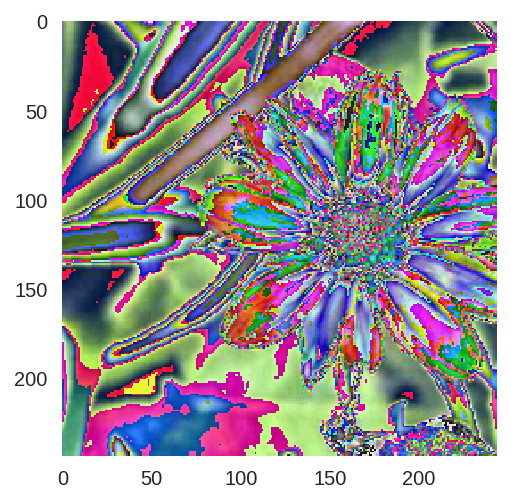

In [0]:
# Show an example image and label

def image_show(image):
    plt.imshow(transforms.ToPILImage()(image))
    plt.grid(None)  # Remove gridlines which colab has by default

def label_to_text(label):
    return cat_to_name[str(label.item())]

# Show an example image and its label
# This will only look right when the images are not normalised
image, label = [x[0] for x in iter(trainloader).next()]

image_show(image)
print(label_to_text(label))
print(image.shape)

**Note:** The colours look strange because of the `transforms.Normalize()` applied  when the image was loaded. If you temorarily remove this, you'll see a normal-looking image.